In [1]:
%matplotlib inline
import os
from os.path import abspath
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, TwoSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip
import nipype.interfaces.matlab as mlab
matlab_cmd = ''

In [2]:
mlab.MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")
        # If SPM is not in your MATLAB path you should add it here
matlab_cmd = 'users/dima/Applications/MATLAB_R2018ba.app/bin/matlab'

project_path = abspath('../data')


data_dir = os.path.abspath('../data')
project_dir = os.path.abspath
output_dir = os.path.abspath('../data/derivatives/SPM')
working_dir = os.path.abspath('../data/derivatives/SPM/level3/workdir_AB')
preproc_dir = os.path.abspath('preproc')
mask = abspath('../data/derivatives/SPM/level2/group_mask.nii')

In [3]:
import json
from os.path import isfile
from os import listdir
from glob import glob
import os
from os.path import abspath
data_dir = os.path.abspath('../data')


conlist1 = []
import json
with open("AB.json") as f:
    groups = json.load(f)

for key, value in groups.items():
    subject_id = key
    for run_id in list(value):

        results = os.path.join(data_dir, "derivatives", "SPM", "level1",
                                   "sub-%s" % subject_id, "run-0%s" % run_id, "con_0009.nii")
        if isfile(results):
            conlist1.append(results)

In [4]:
conlist2 = []
import json
with open("ABCD.json") as f:
    groups = json.load(f)

for key, value in groups.items():
    subject_id = key
    for run_id in list(value):

        results = os.path.join(data_dir, "derivatives", "SPM", "level1",
                                   "sub-%s" % subject_id, "run-0%s" % run_id, "con_0005.nii")
        if isfile(results):
            conlist2.append(results)

In [5]:
print(conlist1, conlist2)

['/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-03/run-03/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-03/run-05/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-04/run-03/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-04/run-05/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-05/run-03/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-05/run-05/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-06/run-03/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-06/run-05/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-07/run-03/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-07/run-05/con_0009.nii', '/Users/dima/Desktop/odormixture/data/derivatives/SPM/level1/sub-09/run-04/con_0009.nii', '/Users/d

In [6]:
# OneSampleTTestDesign - creates one sample T-Test Design
twosamplettestdes = Node(TwoSampleTTestDesign(),
                         name="twosampttestdes")
twosamplettestdes.inputs.group1_files = conlist1
twosamplettestdes.inputs.group2_files = conlist2

twosamplettestdes.inputs.explicit_mask_file = mask


# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
con_1 = ('AB','T', ['Group_{1}'],[1])
con_2 = ('A_plus_B','T', ['Group_{2}'],[1])
con_3 = ('AB_vs_A_plus_B','T',['Group_{1}','Group_{2}'],[1,-1])
con_4 = ('A_plus_B_vs_AB','T',['Group_{1}','Group_{2}'],[-1,1])
level2conestimate.inputs.contrasts = [con_1,con_2,con_3,con_4]
level2conestimate.inputs.group_contrast = True


# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")
# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=output_dir, parameterization=False,
                                 container='level3/twosamplettest'),
                        name="datasink")

In [7]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='level2')
l2analysis.base_dir = working_dir

# Connect up the 2nd-level analysis components
l2analysis.connect([(twosamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                   # (level2conestimate, level2thresh, [('spm_mat_file',
                    #                                    'spm_mat_file'),
                     #                                  ('spmT_images',
                      #                                  'stat_image'),
                       #                                ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '@spm_mat'),
                                                   ('spmT_images',
                                                    '@T'),
                                                   ('con_images',
                                                    '@con')]),
                    #(level2thresh, datasink, [('thresholded_map',
                                             #  '@threshold')]),
                    ])

190227-18:13:00,835 nipype.workflow INFO:
	 Generated workflow graph: /Users/dima/Desktop/odormixture/data/derivatives/SPM/level3/workdir_AB/level2/graph.png (graph2use=colored, simple_form=True).


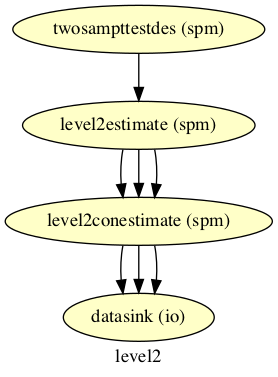

In [8]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'level2', 'graph.png'))

In [9]:
l2analysis.run('MultiProc')

190227-18:13:00,892 nipype.workflow INFO:
	 Workflow level2 settings: ['check', 'execution', 'logging', 'monitoring']
190227-18:13:00,908 nipype.workflow INFO:
	 Running in parallel.
190227-18:13:00,912 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 4/4.
190227-18:13:01,36 nipype.workflow INFO:
	 [Node] Setting-up "level2.twosampttestdes" in "/Users/dima/Desktop/odormixture/data/derivatives/SPM/level3/workdir_AB/level2/twosampttestdes".
190227-18:13:01,55 nipype.workflow INFO:
	 [Node] Running "twosampttestdes" ("nipype.interfaces.spm.model.TwoSampleTTestDesign")
190227-18:13:02,914 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 3/4.
                     Currently running:
                       * level2.twosampttestdes
190227-18:13:54,531 nipype.workflow INFO:
	 [Node] Finished "level2.twosampttestdes".
190227-18:13:54,977 nipype.workflow INFO